In [40]:
import requests
import csv
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from collections import Counter

# Total number of levels including level0
number_of_levels = 5 # TODO

# Analytics mode
mode = 'test'
# mode = 'production'

test_url = 'https://side-n-top-default-rtdb.firebaseio.com/test/.json'
production_url = 'https://side-n-top-default-rtdb.firebaseio.com/events/.json'

test_file = 'test.csv'
production_file = 'production.csv'

url = test_url if mode == 'test' else production_url
out_put_file = test_file if mode == 'test' else production_file

In [2]:
response = requests.get(url)
if response.status_code == 200:
    data = response.json()
    # print(data)
else:
    print("Failure Request：", response.status_code)

In [3]:
# Extract all events into a csv
all_events = []
for key, value in data.items():
    if isinstance(value, dict) and 'events' in value:
        all_events.extend(value['events'])
        
fieldnames = all_events[0].keys()
with open(out_put_file, 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerows(all_events)

print(f"CSV file saved as {out_put_file} with {len(all_events)} rows.")

CSV file saved as test.csv with 37 rows.


In [4]:
# Group events by their SessionID
grouped_events = {}

for event in all_events:
    session_id = event.get('sessionId')
    if session_id not in grouped_events:
        grouped_events[session_id] = []
    grouped_events[session_id].append(event)

for session_id, events in grouped_events.items():
    print(f"There are {len(events)} events in SessionID: {session_id}")

There are 2 events in SessionID: e9866df9-e633-4ddd-a39a-a411ecc662cb
There are 2 events in SessionID: 84cfa709-9656-40c6-8794-8926fecbdeae
There are 2 events in SessionID: 999ff3eb-c61b-44da-a31e-e8d1ebb744bc
There are 2 events in SessionID: f1ac48de-b2d6-4d01-837a-041fc52d5d81
There are 6 events in SessionID: 104d73f7-6481-465c-9339-9322c3ea65f0
There are 2 events in SessionID: 2e938678-580e-48e6-a32a-50d454c35cf9
There are 3 events in SessionID: 7a9c20d9-23e8-4561-aa3b-bddd8e019f22
There are 3 events in SessionID: 2f6a5d17-d071-4b15-a6a5-437489aad509
There are 6 events in SessionID: 76a03242-ebf9-4c6a-8f9b-9dc5edc14831
There are 2 events in SessionID: 81fc0a54-8f98-4571-a630-b8453b1e3159
There are 3 events in SessionID: d4e6c006-9e99-46f1-888e-8cc35ebd901d
There are 4 events in SessionID: 94b7fc96-88e4-402f-88d6-706f5c063907


In [18]:
# TODO
# number_of_levels = 5
level_dict = {f'Level{i}': i for i in range(number_of_levels)}
# Metric 1
end_causes_by_level = [{} for _ in range(number_of_levels)]
# Metric 2
total_number_of_shift_by_level = [0] * number_of_levels
total_number_of_session_by_level = [0] * number_of_levels
average_number_of_shift_by_level = [0] * number_of_levels
# Metric 3
average_interval_of_shift_by_session_by_level = [[] for _ in range(number_of_levels)]
average_interval_of_shift_by_level = [0] * number_of_levels
# Metric 4
average_topdown_time_by_session_by_level = [[] for _ in range(number_of_levels)]
average_topdown_ratio_by_level = [0] * number_of_levels

for session_id, events in grouped_events.items():
    if len(events) < 2:
        continue

    # Sort events by timestamp
    events = sorted(events, key=lambda x: x.get('timestamp', 0))
    level_id = events[0].get('levelId')
    level_idx = level_dict[level_id]
    
    is_topdown = events[0].get('viewBeforeEvent') == 'TopDown' # Initial state
    topdown_time = 0
    platformer_time = 0
    end = 'Win'
    shift_count = 0
    for i in range(1, len(events)):
        event = events[i]
        prev_event = events[i - 1]

        # Sum topdown_time or platformer_time
        time_interval = event.get('timestamp', 0) - prev_event.get('timestamp', 0)
        if event.get('eventType') in ['Lose', 'Win', 'Shift']:
            if is_topdown:
                topdown_time += time_interval
            else:
                platformer_time += time_interval

            # Shift on shift event
            if event.get('eventType') == 'Shift':
                shift_count += 1
                is_topdown = not is_topdown

            # End an analytics session
            if event.get('eventType') == 'Win':
                end = 'Win'
                
            if event.get('eventType') == 'Lose':
                end = event.get('reason')

    # For each session, calculate each metric
    total_time = topdown_time + platformer_time
    # Metric 1
    if end not in end_causes_by_level[level_idx]:
        end_causes_by_level[level_idx][end] = 1
    else:
        end_causes_by_level[level_idx][end] += 1
    # Metric 2
    total_number_of_shift_by_level[level_idx] += shift_count
    total_number_of_session_by_level[level_idx] += 1
    # Metric 3
    average_interval_of_shift_by_session = total_time / shift_count / 1000 if shift_count != 0 else 0
    average_interval_of_shift_by_session_by_level[level_idx].append(average_interval_of_shift_by_session)
    # Metric 4
    average_topdown_time_by_session = topdown_time / total_time if total_time != 0 else 0
    average_topdown_time_by_session_by_level[level_idx].append(average_topdown_time_by_session)

for i in range(number_of_levels):
    # Metric 1
    # end_causes_by_level
    # Metric 2
    average_number_of_shift_by_level[i] = (total_number_of_shift_by_level[i] / total_number_of_session_by_level[i] 
                                           if total_number_of_session_by_level[i] != 0 else 0)
    # Metric 3
    average_interval_of_shift_by_level[i] = (sum(average_interval_of_shift_by_session_by_level[i]) / 
                                             len(average_interval_of_shift_by_session_by_level[i])
                                            if len(average_interval_of_shift_by_session_by_level[i]) != 0 else 0)
    # Metric 4
    average_topdown_ratio_by_level[i] = (sum(average_topdown_time_by_session_by_level[i]) / 
                                         len(average_topdown_time_by_session_by_level[i]) 
                                         if len(average_topdown_time_by_session_by_level[i]) != 0 else 0)

print("--------------------Metric 1-------------------------")
print(end_causes_by_level)
print()
print("--------------------Metric 2-------------------------")
print(average_number_of_shift_by_level)
print()
print("--------------------Metric 3-------------------------")
print(average_interval_of_shift_by_level)
print()
print("--------------------Metric 4-------------------------")
print(average_topdown_ratio_by_level)

--------------------Metric 1-------------------------
[{'KillZone': 1, 'Win': 1}, {'Pit': 1, 'Win': 1}, {'Win': 1}, {'KillZone': 1, 'Pit': 1, 'MovingCylinder': 1, 'Win': 1}, {'KillZone': 1, 'Pit': 1, 'Win': 1}]

--------------------Metric 2-------------------------
[0.0, 0.0, 4.0, 1.5, 1.0]

--------------------Metric 3-------------------------
[0.0, 0.0, 5.4085, 3.665375, 5.9095]

--------------------Metric 4-------------------------
[0.0, 1.0, 0.33840251456041415, 0.4921775033584177, 0.4818090817372697]


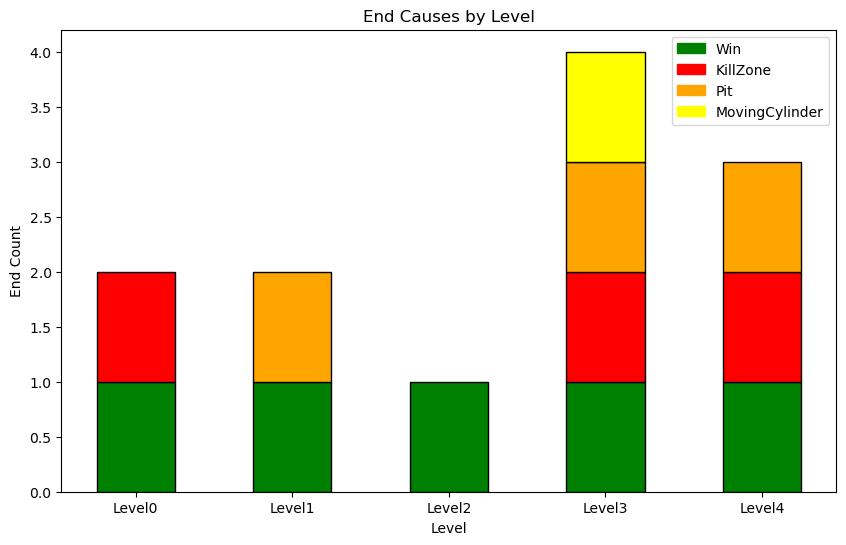

In [44]:
# -------------------- Metric 1: End Causes by Level --------------------
levels = [f'Level{i}' for i in range(len(end_causes_by_level))]
color_mapping = {
    "Win": "green",
    "KillZone": "red",
    "Pit": "orange",
    "MovingCylinder": "yellow"
} # TODO
default_color = "gray"
bar_width = 0.5

plt.figure(figsize=(10, 6))
for i, causes in enumerate(end_causes_by_level):
    bottom = 0
    # Sort causes so that 'Win' is always drawn first (at the bottom)
    sorted_causes = sorted(causes.items(), key=lambda x: 0 if x[0] == "Win" else 1)
    for cause, count in sorted_causes:
        color = color_mapping.get(cause, default_color)
        plt.bar(levels[i], count, bottom=bottom, width=bar_width, color=color, edgecolor='black', 
                label=cause if i == 0 else "")
        bottom += count

plt.xlabel('Level')
plt.ylabel('End Count')
plt.title('End Causes by Level')
legend_handles = [mpatches.Patch(color=color, label=cause) for cause, color in color_mapping.items()]
plt.legend(handles=legend_handles)
plt.show()

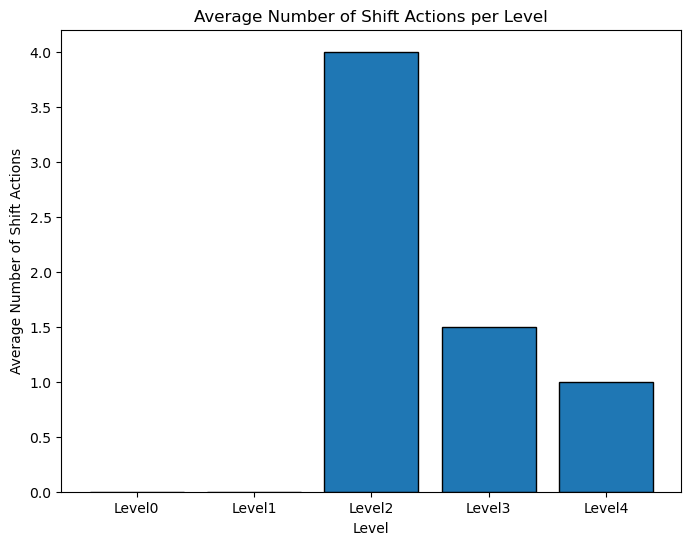

In [36]:
# -------------------- Metric 2: Average Number of Shift Actions per Level --------------------
plt.figure(figsize=(8, 6))
plt.bar(levels, average_number_of_shift_by_level, edgecolor='black')
plt.xlabel('Level')
plt.ylabel('Average Number of Shift Actions')
plt.title('Average Number of Shift Actions per Level')
plt.show()

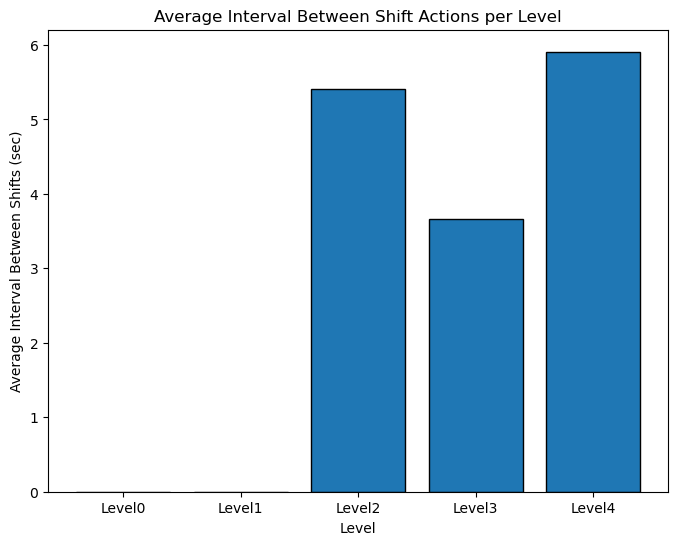

In [34]:
# -------------------- Metric 3: Average Interval Between Shift Actions per Level --------------------
plt.figure(figsize=(8, 6))
plt.bar(levels, average_interval_of_shift_by_level, edgecolor='black')
plt.xlabel('Level')
plt.ylabel('Average Interval Between Shifts (sec)')
plt.title('Average Interval Between Shift Actions per Level')
plt.show()

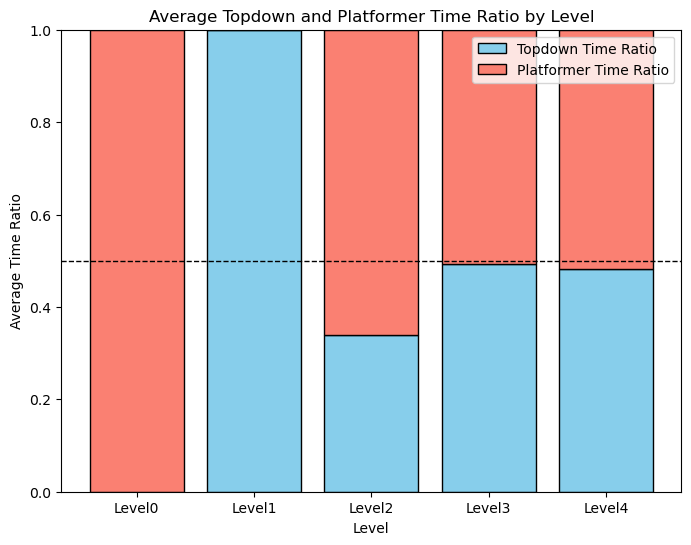

In [32]:
# -------------------- Metric 4: Average Topdown and Platformer Time Ratio by Level --------------------
average_platformer_time_by_level = [1 - x for x in average_topdown_ratio_by_level]

plt.figure(figsize=(8, 6))
# Plot topdown ratio as the base, then stack platformer ratio on top.
plt.bar(levels, average_topdown_ratio_by_level, edgecolor='black', label='Topdown Time Ratio', color='skyblue')
plt.bar(levels, average_platformer_time_by_level, edgecolor='black', bottom=average_topdown_ratio_by_level, 
        label='Platformer Time Ratio', color='salmon')
plt.axhline(y=0.5, color='black', linestyle='--', linewidth=1)
plt.xlabel('Level')
plt.ylabel('Average Time Ratio')
plt.title('Average Topdown and Platformer Time Ratio by Level')
plt.legend()
plt.show()

In [6]:
# levels = list(level_dict.keys())  # e.g., ['Level0', 'Level1', 'Level2']
# average_platformer_time_by_level = [1 - t for t in average_topdown_ratio_by_level]

# plt.figure(figsize=(8, 6))
# # Plot the topdown time ratio as the base of the bar
# plt.bar(levels, average_topdown_ratio_by_level, edgecolor='black', label='Topdown Time Ratio', color='skyblue')
# # Plot the platformer time ratio on top of the topdown time ratio
# plt.bar(levels, average_platformer_time_by_level, edgecolor='black', bottom=average_topdown_ratio_by_level, label='Platformer Time Ratio', color='salmon')

# plt.xlabel('Level')
# plt.ylabel('Average Time Ratio')
# plt.title('Average Topdown and Platformer Time Ratio by Level')
# plt.legend()
# plt.show()